# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from VeloceReduction import config
import VeloceReduction as VR

from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from VeloceReduction.utils import polynomial_function

## Adjust Date and Directory (possibly via argument parser)

In [2]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"
        
#         jupyter_date = "240201"
        
        jupyter_working_directory = "./"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date
config.working_directory = args.working_directory
print(f"Date: {args.date}, Working Directory: {args.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 001122, Working Directory: ./


## Identfiy Calibration and Science Runs

In [3]:
# Extract the Calibration and Science data from the night log
calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(config.date, config.working_directory+'observations/')



Identifying calibration and science runs now

Found Log file ./observations//001122/001122-AAT-example.log


No Bstar observations were identified.

The following science observations were identified: HIP69673


## Extract orders and save in initial FITS files with an extension per order.

In [4]:
# Extract order ranges and coefficients
order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

In [5]:
# # Extract Master Flat
# print('Extracting Master Flat')
# master_flat, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['Flat_60.0'][:1],
#     ccd2_runs = calibration_runs['Flat_1.0'][:1],
#     ccd3_runs = calibration_runs['Flat_0.1'][:1],
#     Flat = True,
#     update_tramlines_based_on_flat = False, # Would update and overwrite
#     # ./VeloceReduction/tramline_information/tramline_begin_end_ccd_*_oder_*.txt
#     debug_overscan = False,
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines_flat.pdf
# )

# # Extract Master ThXe
# print('Extracting Master ThXe')
# master_thxe, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['FibTh_180.0'][:1],
#     ccd2_runs = calibration_runs['FibTh_60.0'][:1],
#     ccd3_runs = calibration_runs['FibTh_15.0'][:1],
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines.pdf
# )

# # Extract Master LC
# print('Extracting Master LC')
# master_lc, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['SimLC'][-1:],
#     ccd2_runs = calibration_runs['SimLC'][-1:],
#     ccd3_runs = calibration_runs['SimLC'][-1:],
#     LC = True,
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines_lc.pdf
# )

In [6]:
# # Extract Science Objects and save them into FITS files under reduced_data/
# for science_object in list(science_runs.keys()):
#     print('Extracting '+science_object)
#     try:
#         science, science_noise, science_header = VR.extraction.extract_orders(
#             ccd1_runs = science_runs[science_object],
#             ccd2_runs = science_runs[science_object],
#             ccd3_runs = science_runs[science_object],
#             Science=True,
#             debug_tramlines = False, # Would create a tramlines trace PDF under
#             # ./VeloceReduction/tramline_information/debug_tramlines_science.pdf
#             debug_overscan=False
#         )

#         # Create a primary HDU and HDU list
#         primary_hdu = fits.PrimaryHDU()
#         header = primary_hdu.header
#         header['OBJECT']             = (science_header['OBJECT'], 'Name of observed object in night log')
#         header['HIERARCH SOURCE_ID'] = (-1,                       'Gaia DR3 source_id')
#         header['HIERARCH TMASS_ID']  = ('HHMMSSSS-DDMMSSS',       'Identifier in 2MASS catalog')
#         header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
#         header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
#         header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
#         header['BARYVEL']            = ('None',                   'Applied barycentric velocity correction')
#         header['VRAD']               = ('None',                   'Radial velocity estimate')
#         header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')
#         hdul = fits.HDUList([primary_hdu])

#         # Loop over your extension names and corresponding data arrays
#         for ext_index, ext_name in enumerate(order_beginning_coeffs):
#             # Create an ImageHDU object for each extension
            
#             # Apply flat-field calibration to science
#             science[ext_index,:] /= master_flat[ext_index,:]
#             science_noise[ext_index,:] /= master_flat[ext_index,:]
            
#             # Apply rough renormalisation with outlier-robuster 99th percenile of ~middle of order
#             science_99percentile = np.nanpercentile(science[ext_index,1500:2500],q=99)
#             science[ext_index,:] /= science_99percentile
#             science_noise[ext_index,:] /= science_99percentile
            
#             # Define the columns with appropriate formats
#             col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
#             col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
#             col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
#             col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:]/master_flat[ext_index,:])
#             col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:]/master_flat[ext_index,:])

#             # Combine columns to BinTable and add header from primary
#             hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def], name=ext_name.lower())
#             hdu.header.extend(header.copy(strip=True), unique=True)
            
#             # Append the HDU to the HDU list
#             hdul.append(hdu)

#         # Save to a new FITS file with an extension for each order
#         Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
#         spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
#         hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

#         print('  -> Successfully extracted '+science_object)

#     except:
#         print('  -> Failed to extract '+science_object)

## Wavelength calibration

Calibrating wavelength for HIP69673
  -> Correcting for barycentric velocity: -21.07 km/s
  -> Estimating rough Radial Velocity from Halpha and CaII triplet
  -> Fitting Halpha, but neglecting for RV estimate.
  -> $v_\mathrm{rad}  = -4.6 \pm 0.8 \pm 0.7\,\mathrm{km\,s^{-1}}$ (mean, scatter, uncertainty)


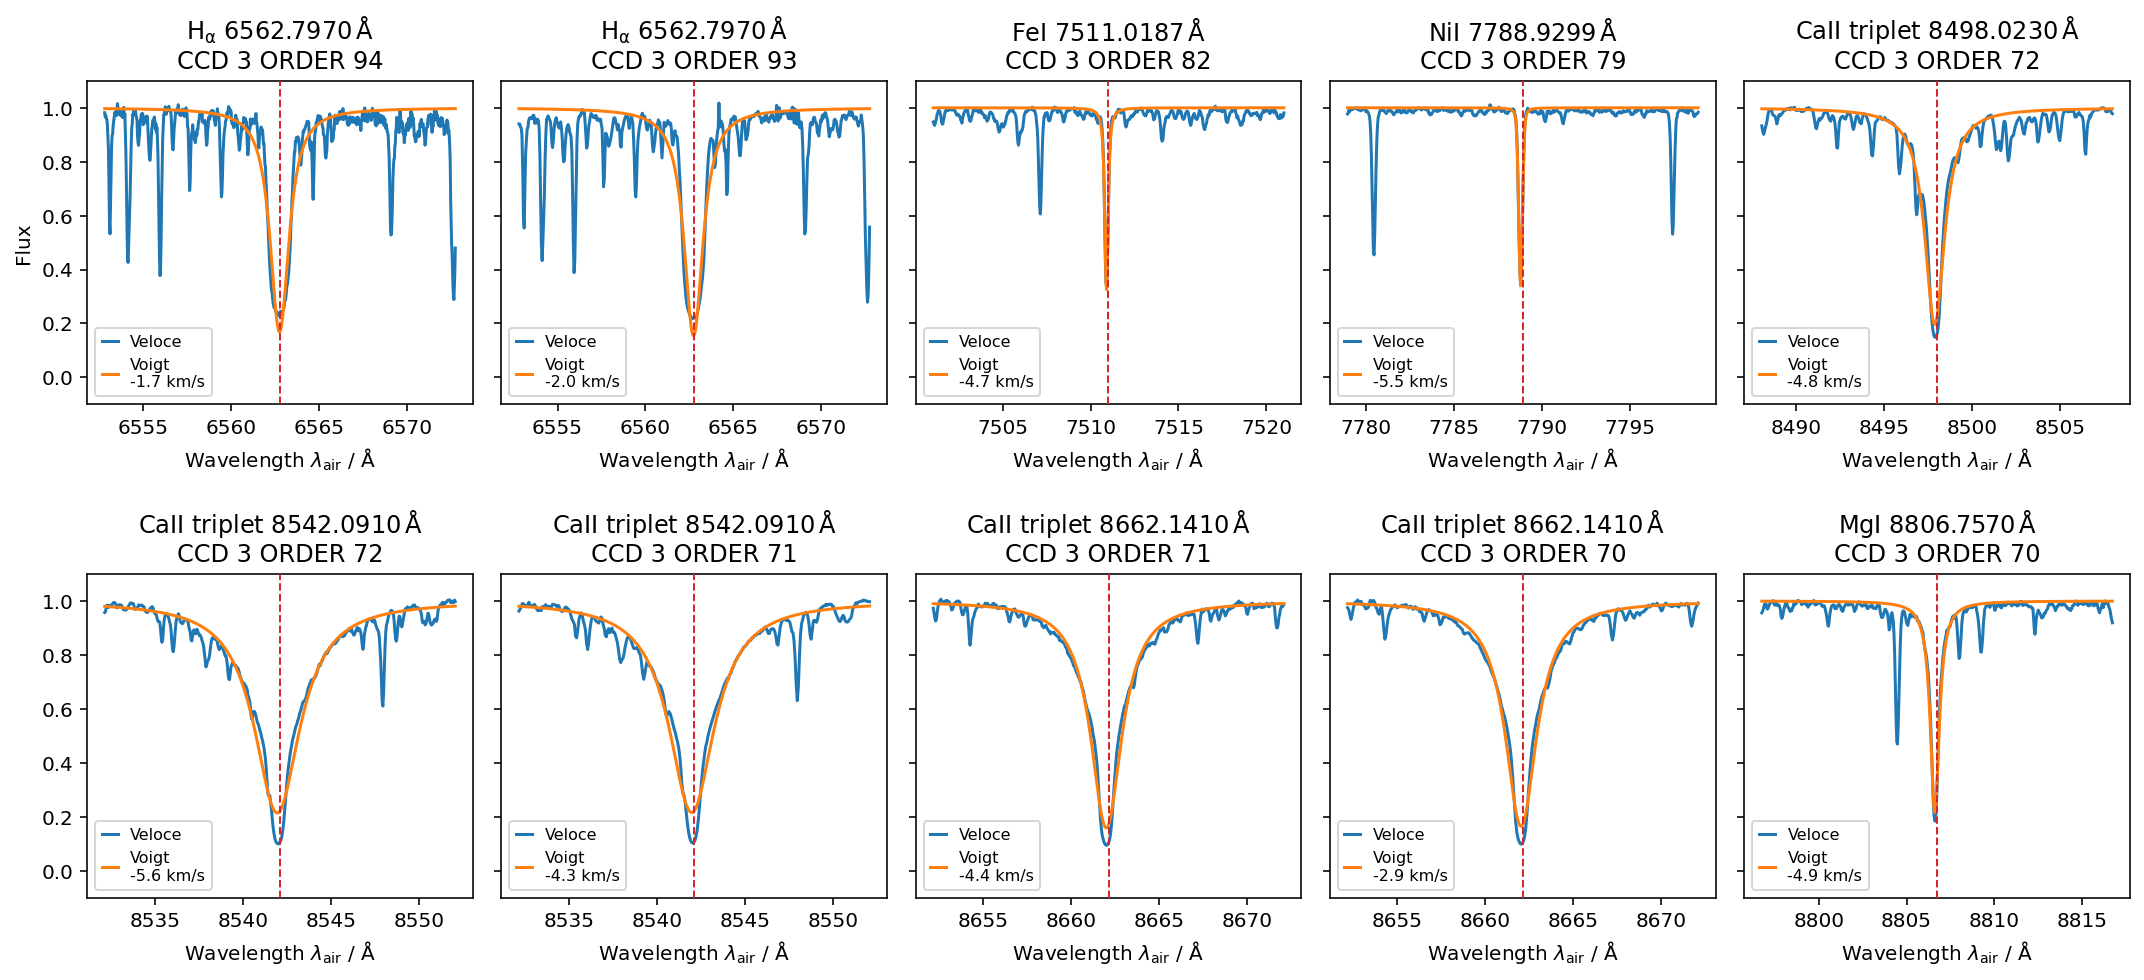

  -> Not creating overview PDF.


In [7]:
for science_object in list(science_runs.keys()):
#     try:
    VR.calibration.calibrate_wavelength(
        science_object,
        correct_barycentric_velocity=True,
        create_overview_pdf=False
    )
#         print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object)
#     except:
#         print('  -> Failed to calibrate wavelength for '+science_object)

## DELETE WHEN DONE! LASER COMB

In [8]:
# sys.exit()

In [9]:
science_object = 'HIP69673'
input_output_directory = config.working_directory+'reduced_data/'+config.date+'/'+science_object

spectrum = dict()

with fits.open(input_output_directory+'/veloce_spectra_'+science_object+'_'+config.date+'.fits', mode='update') as file:
    
    for index in range(1,len(file)):

        spectrum[file[index].header['EXTNAME'].lower()] = Table()
        for key in ['wave_vac','wave_air','science','science_noise','flat','thxe','lc']:
            spectrum[file[index].header['EXTNAME'].lower()][key] = file[index].data[key]
            
coeffs_tinney = VR.utils.read_in_wavelength_solution_coefficients_tinney()


150 3980
Found 12 gaps:  [209 224 240 255 270 285 301 317 332 347 362 394]


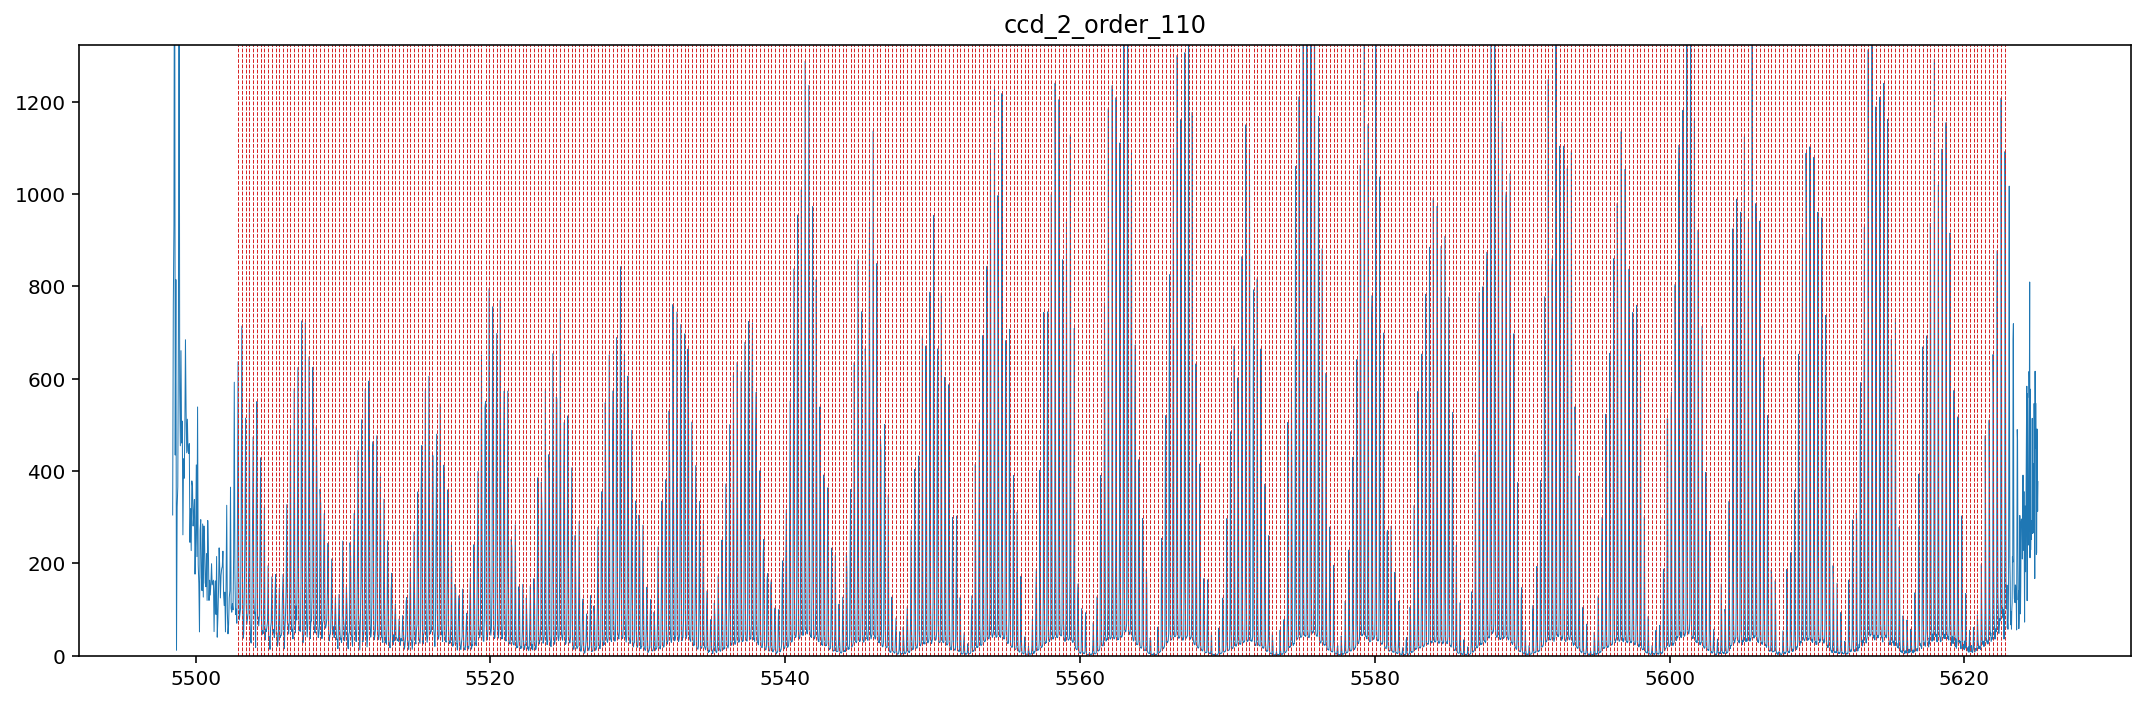

Failed fit for peak 142 at position 292
peaks:  465
modes:  465
Refitting wavelength solution after clipping 7 3-sigma RMS velocity outliers:  [ 195.  207.  292.  328.  409.  415. 1955.]
0.06535911455574496


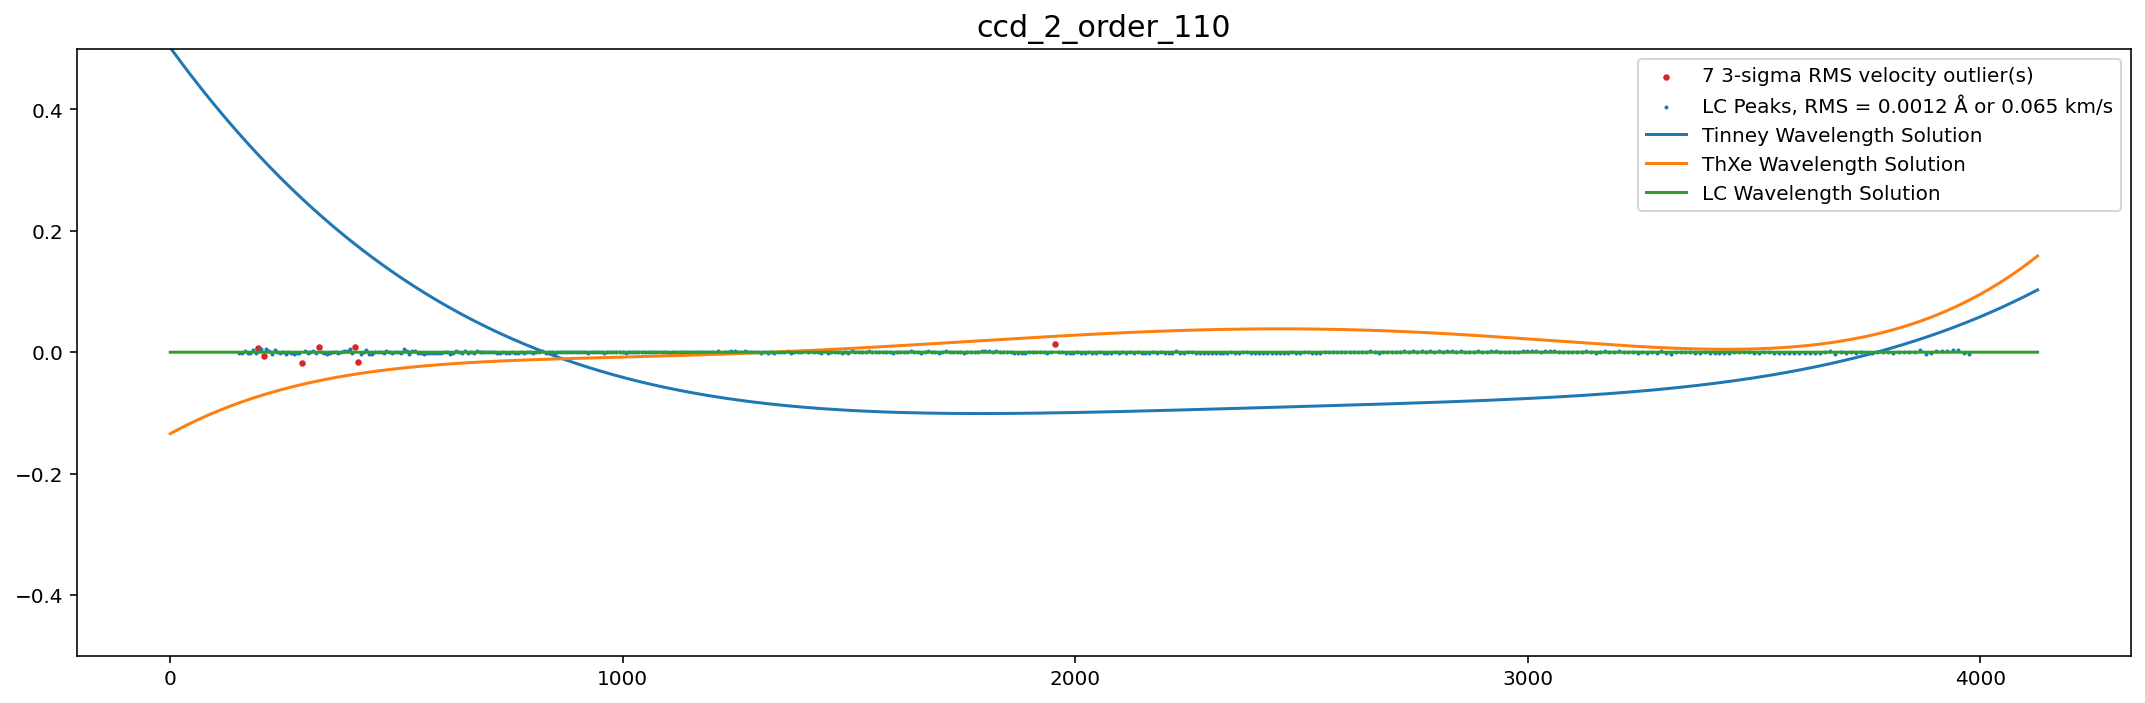

In [17]:
lc_range = dict()
lc_range['ccd_3_order_104'] = [1455,3900]
lc_range['ccd_3_order_103'] = [780,3900]
lc_range['ccd_3_order_102'] = [700,3900]
lc_range['ccd_3_order_101'] = [650,3920]
lc_range['ccd_3_order_100'] = [600,3820]
lc_range['ccd_3_order_99'] = [490,3800]
lc_range['ccd_3_order_98'] = [500,3750]
lc_range['ccd_3_order_97'] = [325,3775]
lc_range['ccd_3_order_96'] = [255,3720]
lc_range['ccd_3_order_95'] = [250,3650]
lc_range['ccd_3_order_94'] = [450,3650]
lc_range['ccd_3_order_93'] = [270,3600]
lc_range['ccd_3_order_92'] = [540,2800]
lc_range['ccd_3_order_91'] = [630,3525]
lc_range['ccd_3_order_90'] = [490,3525]
lc_range['ccd_3_order_89'] = [355,3465]
lc_range['ccd_3_order_88'] = [400,2900]
lc_range['ccd_3_order_87'] = [505,3245]
lc_range['ccd_3_order_86'] = [200,3200]
lc_range['ccd_3_order_85'] = [455,3655]
lc_range['ccd_3_order_84'] = [150,3578]
lc_range['ccd_3_order_83'] = [145,3850]
lc_range['ccd_3_order_82'] = [120,3870]
lc_range['ccd_3_order_81'] = [125,4050]
lc_range['ccd_3_order_80'] = [130,4000]
lc_range['ccd_3_order_79'] = [120,4070]
lc_range['ccd_3_order_78'] = [100,4100]
lc_range['ccd_3_order_77'] = [100,4100]
lc_range['ccd_3_order_76'] = [105,4095]
lc_range['ccd_3_order_75'] = [99,4050]
lc_range['ccd_3_order_74'] = [745,4050]
lc_range['ccd_3_order_73'] = [99,4100]
lc_range['ccd_3_order_72'] = [125,4090]
lc_range['ccd_3_order_71'] = [95,4086]
lc_range['ccd_3_order_70'] = [110,4077]
lc_range['ccd_3_order_69'] = [90,4087]
lc_range['ccd_3_order_68'] = [90,4090]
lc_range['ccd_3_order_67'] = [100,4090]
lc_range['ccd_3_order_66'] = [100,3730]

lc_range = dict()
lc_range['ccd_2_order_134'] = [1600,3850]
lc_range['ccd_2_order_133'] = [1700,3850]
lc_range['ccd_2_order_132'] = [1700,3850]
lc_range['ccd_2_order_131'] = [1550,3850]
lc_range['ccd_2_order_130'] = [1430,3950]

lc_range['ccd_2_order_110'] = [150,3980]
lc_range['ccd_2_order_109'] = [430,3730]
lc_range['ccd_2_order_108'] = [320,3500]
lc_range['ccd_2_order_107'] = [215,3580]
lc_range['ccd_2_order_106'] = [215,3455]
lc_range['ccd_2_order_105'] = [150,3680]
lc_range['ccd_2_order_104'] = [200,3200]
lc_range['ccd_2_order_103'] = [140,3200]

orders = ['ccd_2_order_110']

use_ylim = True
overwrite = True
debug = False

# for order in list(spectrum.keys()):
# for order in lc_range.keys(): 
for order in orders: 
    if (order[4] != '1') & (order != 'ccd_3_order_65'):

        thxe_file_path = './VeloceReduction/veloce_reference_data/thxe_pixels_and_positions/' + order + '_px_wl.txt'
        thxe_pixels_and_wavelengths = np.array(np.loadtxt(thxe_file_path))

        # Fit a polynomial function to pixel and wavelength data
        coeffs_thxe, _ = curve_fit(
            polynomial_function,
            thxe_pixels_and_wavelengths[:,0] - 2064,
            thxe_pixels_and_wavelengths[:,1],
            p0=[np.median(thxe_pixels_and_wavelengths[:,1]), 0.05, 0.0, 0.0, 0.0, 0.0]
        )
        
        if order in lc_range.keys():
            lc_beginning, lc_ending = lc_range[order]
        else:
            lc_beginning = 100
            lc_ending = 4000
            
        print(lc_beginning,lc_ending)

        # Plot LC positions
        wavelength = spectrum[order]['wave_vac']
        wavelength = polynomial_function(np.arange(4128)-2064,*coeffs_thxe)*10
        
        lc_values = spectrum[order]['lc']
        
        in_panel = np.arange(lc_beginning,lc_ending+1)
        close_to_in_panel = np.arange(lc_beginning-100,np.min([lc_ending+100,4127]))

        f, ax = plt.subplots(1,1,figsize=(15,5))
        ax.set_title(order)
        ax.plot(
            wavelength[close_to_in_panel],
            lc_values[close_to_in_panel],
            lw = 0.5
        )
        ax.set_ylim(0,1.1*np.percentile(lc_values[np.isfinite(lc_values)],q=99))
        
        if order[4] == '3':
            peak_distance = 7
        else:
            peak_distance = 6
        peak_height = 20
        peak_prominence = 20
        
        if order in ['ccd_3_order_80','ccd_3_order_81','ccd_3_order_90','ccd_3_order_92','ccd_3_order_88']:
            peak_height = 10
            peak_prominence = 10

        if order in ['ccd_3_order_86','ccd_2_order_104','ccd_2_order_105']:
            peak_height = 5
            peak_prominence = 5
            
        if order in ['ccd_3_order_87','ccd_3_order_91']:
            peak_height = 1
            peak_prominence = 3

        if order in ['ccd_2_order_106','ccd_2_order_107','ccd_2_order_108','ccd_2_order_109']:
            peak_height = 2
            peak_prominence = 2

        peaks, peak_metadata = find_peaks(
            lc_values[in_panel],
            height = peak_height,
            prominence = peak_prominence,
            distance = peak_distance
        )
        
        # Identify gaps (>1.5 median_peak_distance) that are not within the first 50 and last 600 pixels
        median_peak_distance = np.median(np.diff(peaks))
        position_of_too_large_gap_between_peaks = np.where((np.diff(peaks) > 1.5*median_peak_distance) & (peaks[:-1] > 50) & (peaks[:-1] < lc_ending - 600))[0]
        if len(position_of_too_large_gap_between_peaks) > 0:
            print('Found '+str(len(position_of_too_large_gap_between_peaks))+' gaps: ', position_of_too_large_gap_between_peaks)
        
        # Initialize the new peaks list from existing peaks
        new_peaks = list(peaks)

        # Insert new peaks in the positions of the large gaps and overwrite peaks
        for index in reversed(position_of_too_large_gap_between_peaks):
            start_peak = peaks[index]
            end_peak = peaks[index + 1]
            new_peak_position = (start_peak + end_peak) // 2
            new_peaks.insert(index + 1, new_peak_position)
        peaks = new_peaks
        
        for peak in peaks:
            ax.axvline(wavelength[in_panel][peak], c = 'C3', lw=0.5, ls='dashed')

        plt.tight_layout()
        plt.show()
        plt.close()
        
        fine_peaks = []
        
        for peak in peaks:
            
            # Find the pixels that are +- 0.5*peak_distance away from the peak
            pixels_around_peak = np.arange(
                np.max([0,peak - int(np.ceil(peak_distance/2))]),
                np.min([len(lc_values[in_panel]),peak + int(np.ceil(peak_distance/2))+1])
            )
            pixel_values_around_peak = lc_values[in_panel][pixels_around_peak]
            pixel_minmax = list(np.nanpercentile(pixel_values_around_peak,q=[1,99]))
            
            try:
                popt, pcov = curve_fit(
                    VR.utils.lc_peak_gauss,
                    pixels_around_peak,
                    pixel_values_around_peak,
                    p0 = [peak, 1, pixel_minmax[1]-pixel_minmax[0], pixel_minmax[0]]
                )
                
                # Make sure the Gaussian is not too far off!
                # Use initial peak integer otherwise
                if abs(peak - popt[0] > 1):
                    fine_peaks.append(peak)
                else:
                    fine_peaks.append(popt[0])
            except:
                print('Failed fit for peak '+str(peak)+' at position '+str(peak+lc_beginning))
                fine_peaks.append(peak)

            if debug:
                f, ax = plt.subplots(1,1)
                ax.scatter(
                    pixels_around_peak,
                    pixel_values_around_peak,
                    s = 20
                )

                ax.plot(
                    np.linspace(pixels_around_peak[0],pixels_around_peak[-1],50),
                    VR.utils.lc_peak_gauss(np.linspace(pixels_around_peak[0],pixels_around_peak[-1],50), *popt),
                    c = 'C1'
                )

                plt.tight_layout()
                plt.show()
                plt.close()
                
        fine_peaks = np.array(fine_peaks)

        lc_number_upper = np.floor(VR.utils.lasercomb_numbers_from_wavelength(wavelength[in_panel][0]))
        lc_number_lower = np.ceil(VR.utils.lasercomb_numbers_from_wavelength(wavelength[in_panel][-1]))
        lc_wavelengths = VR.utils.lasercomb_wavelength_from_numbers(np.arange(lc_number_lower, lc_number_upper+1))[::-1]

        print('peaks: ',len(peaks))
        print('modes: ',len(lc_wavelengths))
        
        if len(peaks) != len(lc_wavelengths):
            use_peaks_and_modes = np.min([len(peaks),len(lc_wavelengths)])
            print('Only using first '+str(use_peaks_and_modes)+' entries')
        else:
            use_peaks_and_modes = len(peaks)

        
        plt.figure(figsize=(15,5))
        plt.title(order,fontsize=15)

        lc_pixels_to_fit = lc_beginning + fine_peaks[:use_peaks_and_modes] - 2064
        lc_wavelengths_to_fit = lc_wavelengths[:use_peaks_and_modes]
            
        # Fit a polynomial function to pixel and wavelength data
        coeffs_lc, _ = curve_fit(
            polynomial_function,
            lc_pixels_to_fit,
            lc_wavelengths_to_fit/10.,
            p0=[np.median(lc_wavelengths_to_fit), 0.05, 0.0, 0.0, 0.0, 0.0]
        )
        
        wavelength_residuals = (lc_wavelengths_to_fit - (polynomial_function(lc_pixels_to_fit,*coeffs_lc)*10)) # Aangstroem
        rms_wavelength = np.std(wavelength_residuals)
        rms_velocity = 299792.46 * np.std(wavelength_residuals/(lc_wavelengths_to_fit))

        # Calculate X-sigma RMS velocity outliers, clip them, and refit the wavelength solution
        rms_sigma = 3
        rms_velocity_x_sigma_outlier = np.where(299792.46 * np.abs(wavelength_residuals/(lc_wavelengths_to_fit)) / rms_velocity > rms_sigma)[0]
        if len(rms_velocity_x_sigma_outlier) > 0:
            print('Refitting wavelength solution after clipping '+str(len(rms_velocity_x_sigma_outlier))+' '+str(rms_sigma)+'-sigma RMS velocity outliers: ',np.round(lc_pixels_to_fit[rms_velocity_x_sigma_outlier]+2064))
            
            plt.scatter(
                lc_pixels_to_fit[rms_velocity_x_sigma_outlier]+2064,
                lc_wavelengths_to_fit[rms_velocity_x_sigma_outlier] - (polynomial_function(lc_pixels_to_fit[rms_velocity_x_sigma_outlier],*coeffs_lc)*10),
                s = 5, c = 'C3',
                label = str(len(rms_velocity_x_sigma_outlier))+' '+str(rms_sigma)+'-sigma RMS velocity outlier(s)'
            )
            
            lc_pixels_to_fit = np.delete(lc_pixels_to_fit, rms_velocity_x_sigma_outlier)
            lc_wavelengths_to_fit = np.delete(lc_wavelengths_to_fit, rms_velocity_x_sigma_outlier)
            coeffs_lc, _ = curve_fit(
                polynomial_function,
                lc_pixels_to_fit,
                lc_wavelengths_to_fit/10.,
                p0=[np.median(lc_wavelengths_to_fit), 0.05, 0.0, 0.0, 0.0, 0.0]
            )

            wavelength_residuals = lc_wavelengths_to_fit - (polynomial_function(lc_pixels_to_fit,*coeffs_lc)*10) # Aangstroem
            rms_wavelength = np.std(wavelength_residuals)
            rms_velocity = 299792.46 * np.std(wavelength_residuals/lc_wavelengths_to_fit)
            print(rms_velocity)
            
        if overwrite:
            np.savetxt('./VeloceReduction/wavelength_coefficients/wavelength_coefficients_'+order+'_lc.txt',coeffs_lc)

        
        plt.scatter(
            lc_pixels_to_fit+2064,
            (lc_wavelengths_to_fit - (polynomial_function(lc_pixels_to_fit,*coeffs_lc))*10),
            s = 1,
            label = 'LC Peaks, RMS = '+str(np.round(rms_wavelength,4))+' Å or '+str(np.round(rms_velocity,3))+' km/s'
        )
        
        wavelength_tinney = polynomial_function(np.arange(4128)-2450-3,*coeffs_tinney[order][:-1])*10
        if order[4] == '2':
            wavelength_tinney = VR.utils.wavelength_air_to_vac(wavelength_tinney)
        
        plt.plot(
            np.arange(4128),
            wavelength_tinney -
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'Tinney Wavelength Solution'
        )
        
        plt.plot(
            np.arange(4128),
            polynomial_function(np.arange(4128)-2064,*coeffs_thxe)*10 - 
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'ThXe Wavelength Solution'
        )
        plt.plot(
            np.arange(4128),
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10 - 
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'LC Wavelength Solution'
        )
        if use_ylim:
            plt.ylim(-0.5,0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()